## Projeto Machine Learning III

Autores:
- Ana Carolina Ferreira
- Diego Dio
- Fernando Brancher
- Marília Melo
- Mayara Medeiros

### Etapas projeto (apagar para apresentação final):
- Verificar uso de over/undersampling (não sei como faz nem onde se encaixaria)
- Considerando que temos mais de 500mil amostras, fazer uma subamostragem para análise exploratória, etapas subsequentes de testes de modelo, usando o dataset completo somente para rodar o modelo final com os hiperparâmetros já definidos. 
- Análise Exploratória inicial (atualizar análise após divisão do dataset em treino/teste)
    - describe
    - Mostrar dados em gráficos ao invés de tabelas
    - Distribuições de variáveis categóricas e numéricas
    - heatmap de correlação entre variáveis
- Column Transformer, divisão em X_train, X_test, y_train, y_test
    - Stratify no split de treino/teste devido ao desbalanceamento
    - Scaler (ver qual usar de acordo com as distribuições dos dados)
    - OneHot/Ordinal Encoder
- Seleção de features
- PCA para redução de dimensionalidade
- Modelo não supervisionado para verificar clusters de clientes e padrões no dataset
- Teste de 3 ou 4 modelos com grid/random search (lembrar que essa parte costuma demorar)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

## Apresentação

https://www.kaggle.com/datasets/laotse/credit-card-approval

| Feature | Name | Description Remarks |
| --------|-------|--------------------|
| ID |Client Number ||
| CODE_GENDER | Gender ||
| FLAG_OWN_CAR | Is there a car	 ||
| FLAG_OWN_REALTY |	Is there a property ||	
| CNT_CHILDREN | Number of Children ||
| AMT_INCOME_TOTAL | Annual Income ||
| NAME_EDUCATION_TYPE |	Education Level ||
| NAME_FAMILY_STATUS | Marital Status ||
| NAME_HOUSING_TYPE | Way of Living	 ||
| DAYS_BIRTH | Age in days	 ||
| DAYS_EMPLOYED | Duration of work in days	 ||
| FLAG_MOBIL | Is there a mobile phone	 ||
| FLAG_WORK_PHONE |	Is there a work phone	 ||
| FLAG_PHONE | Is there a phone	 ||
| FLAG_EMAIL | Is there an email	 ||
| JOB |	Job	 ||
| BEGIN_MONTHS | Record month | The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on |
| STATUS |	Status | 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month |
| TARGET |	Target  |	Risk user are marked as '1', else are '0' |

### 1. Leitura, tratamento e padronização dos dados

In [9]:
df = pd.read_csv('credit_card_approval.csv')
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
0,5065438,F,Y,N,2+ children,270000.0,Secondary / secondary special,Married,With parents,-13258,-2300,1,0,0,0,Managers,-6,C,0
1,5142753,F,N,N,No children,81000.0,Secondary / secondary special,Single / not married,House / apartment,-17876,-377,1,1,1,0,Private service staff,-4,0,0
2,5111146,M,Y,Y,No children,270000.0,Higher education,Married,House / apartment,-19579,-1028,1,0,1,0,Laborers,0,C,0
3,5010310,F,Y,Y,1 children,112500.0,Secondary / secondary special,Married,House / apartment,-15109,-1956,1,0,0,0,Core staff,-3,0,0
4,5010835,M,Y,Y,2+ children,139500.0,Secondary / secondary special,Married,House / apartment,-17281,-5578,1,1,0,0,Drivers,-29,0,0


In [10]:
print(df.shape)
df.info()

(537667, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537667 entries, 0 to 537666
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   537667 non-null  int64  
 1   CODE_GENDER          537667 non-null  object 
 2   FLAG_OWN_CAR         537667 non-null  object 
 3   FLAG_OWN_REALTY      537667 non-null  object 
 4   CNT_CHILDREN         537667 non-null  object 
 5   AMT_INCOME_TOTAL     537667 non-null  float64
 6   NAME_EDUCATION_TYPE  537667 non-null  object 
 7   NAME_FAMILY_STATUS   537667 non-null  object 
 8   NAME_HOUSING_TYPE    537667 non-null  object 
 9   DAYS_BIRTH           537667 non-null  int64  
 10  DAYS_EMPLOYED        537667 non-null  int64  
 11  FLAG_MOBIL           537667 non-null  int64  
 12  FLAG_WORK_PHONE      537667 non-null  int64  
 13  FLAG_PHONE           537667 non-null  int64  
 14  FLAG_EMAIL           537667 non-null  int64  
 15  JOB 

In [6]:
# Checar valores nulos
df.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
JOB                    0
BEGIN_MONTHS           0
STATUS                 0
TARGET                 0
dtype: int64

### Análise do target

In [7]:
df['TARGET'].value_counts()

TARGET
0    535705
1      1962
Name: count, dtype: int64

<Axes: title={'center': 'Distribuição da aprovação de cartão de crédito'}, xlabel='Aprovação', ylabel='Porcentagem'>

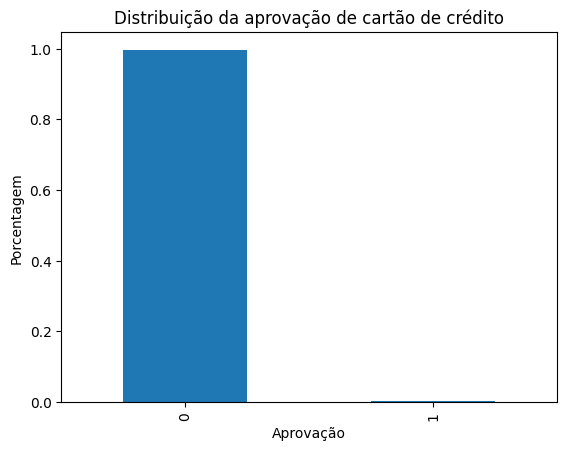

In [7]:
# Análise de balanceamento do target do dataset
df['TARGET'].value_counts(normalize=True).plot(kind='bar', title='Distribuição da aprovação de cartão de crédito',
                                               ylabel='Porcentagem',
                                               xlabel='Aprovação')

### Remoção de valores identificadores

In [9]:
# Remover coluna ID
df.drop('ID', axis=1, inplace=True)
df.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'JOB', 'BEGIN_MONTHS',
       'STATUS', 'TARGET'],
      dtype='object')

### Padronização de tempo em anos

In [10]:
# Converter valores em dias da coluna 'DAYS_BIRTH' para valor absoluto em anos inteiros
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH']) // 365

# Renomear coluna 'DAYS_BIRTH' para 'AGE'
df.rename(columns={'DAYS_BIRTH': 'AGE'}, inplace=True)
df['AGE'].head()

0    36
1    48
2    53
3    41
4    47
Name: AGE, dtype: int64

In [11]:
# Converter valores em dias da coluna 'DAYS_EMPLOYED' para valor absoluto em anos arredondado a uma casa decimal
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: round(abs(x)/365, 1))

# Renomear coluna 'DAYS_EMPLOYED' para 'YEARS_EMPLOYED'
df.rename(columns={'DAYS_EMPLOYED': 'YEARS_EMPLOYED'}, inplace=True)
df['YEARS_EMPLOYED'].head()

0     6.3
1     1.0
2     2.8
3     5.4
4    15.3
Name: YEARS_EMPLOYED, dtype: float64

### Padronização de colunas com valores binários em 0 para False e 1 para True

In [12]:
# Apresentar gráficos ao invés de tabelas das features
# countplot para variáveis categóricas e histogramas para variáveis numéricas

df['FLAG_OWN_CAR'].value_counts()

FLAG_OWN_CAR
N    306207
Y    231460
Name: count, dtype: int64

In [13]:
df['FLAG_OWN_REALTY'].value_counts()

FLAG_OWN_REALTY
Y    345471
N    192196
Name: count, dtype: int64

In [14]:
# Substituir Y por 1 e N por 0 nas colunas 'FLAG_OWN_CAR' e 'FLAG_OWN_REALTY'
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})

# Fazer com o OneHotEncoder?

In [15]:
df['FLAG_OWN_CAR'].value_counts()

FLAG_OWN_CAR
0    306207
1    231460
Name: count, dtype: int64

In [16]:
df['FLAG_OWN_REALTY'].value_counts()

FLAG_OWN_REALTY
1    345471
0    192196
Name: count, dtype: int64

### Análise de colunas categoricas

In [17]:
# Verificar valores da coluna 'CNT_CHILDREN'
df['CNT_CHILDREN'].value_counts()

# Usar OrdinalEncoder?

CNT_CHILDREN
No children    343151
1 children     127695
2+ children     66821
Name: count, dtype: int64

In [18]:
# Verificar valores da coluna 'NAME_EDUCATION_TYPE'
df['NAME_EDUCATION_TYPE'].value_counts()

# Usar OrdinalEncoder

NAME_EDUCATION_TYPE
Secondary / secondary special    358317
Higher education                 153770
Incomplete higher                 20590
Lower secondary                    4556
Academic degree                     434
Name: count, dtype: int64

In [19]:
# Verificar valores da coluna 'NAME_FAMILY_STATUS'
df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 384003
Single / not married     65944
Civil marriage           44083
Separated                31394
Widow                    12243
Name: count, dtype: int64

In [20]:
# Verificar valores da coluna 'NAME_HOUSING_TYPE'
df['NAME_HOUSING_TYPE'].value_counts()

NAME_HOUSING_TYPE
House / apartment      474177
With parents            29351
Municipal apartment     18023
Rented apartment         8561
Office apartment         4159
Co-op apartment          3396
Name: count, dtype: int64

In [21]:
# Verificar valores da coluna 'JOB'
df['JOB'].value_counts()

JOB
Laborers                 131572
Core staff                77112
Sales staff               70362
Managers                  67738
Drivers                   47678
High skill tech staff     31768
Accountants               27223
Medicine staff            26691
Cooking staff             13416
Security staff            12400
Cleaning staff            11399
Private service staff      6714
Low-skill Laborers         3623
Secretaries                3149
Waiters/barmen staff       2557
HR staff                   1686
IT staff                   1319
Realty agents              1260
Name: count, dtype: int64

In [8]:
X = df.drop(columns='TARGET')
y = df['TARGET']